<div style="background-color:yellow; text-align:center; text-align:center; padding:40px;">
<h1  style="color:red;" > DI-725 : Transformers and Attention-Based Deep Networks </h1>   
<h2  style="color:red;" > Assignment - 2 </h2>
<br>
<br>
<h4  style="color:red;" >Turgay Yıldız</h4>
<br>
<h4  style="color:red;" >Graduate School of Informatics,  Middle East Technical University (METU)</h4>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  First Import the Relevant Packages  </h2>
</div>

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch import Tensor
import torchvision

from nltk.tokenize import word_tokenize

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

from torch.optim import AdamW

import json

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tqdm
from PIL import Image

import wandb
import os

from torch.amp import GradScaler, autocast

In [2]:
print(torch.cuda.is_available())

True


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  WANDB </h2>
</div>

In [3]:
print(os.getcwd())

/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Project/Phase_1


In [6]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DI_725_Project_Phase_1__2697258.ipynb" 

In [9]:
wandb.finish() 

In [8]:
run  =  wandb.init(project="Phase_1", entity="DI_725___Final_Project") 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Import Dataset  </h2>
</div>

In [33]:
path            =     "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Project/RISCM/"

In [34]:
images_p        =    os.listdir(path + "resized/")
captions_p      =    path + "captions.csv" 

In [63]:
images_p[:5]

['NWPU_112.jpg',
 'RSICD_6644.jpg',
 'NWPU_28028.jpg',
 'NWPU_14741.jpg',
 'NWPU_20089.jpg']

In [36]:
data   =  pd.read_csv(captions_p)

In [37]:
data.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .


In [52]:
len(data)

44521

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Exploratory Data Analysis (EDA)  </h2>
</div>


In [38]:
data["split"]

0         test
1         test
2         test
3         test
4         test
         ...  
44516    train
44517    train
44518    train
44519    train
44520    train
Name: split, Length: 44521, dtype: object

In [39]:
split_series = data['split']
counts       = split_series.value_counts()

print(counts)

split
train    35614
test      4454
val       4453
Name: count, dtype: int64


In [40]:
num_train = counts.get('train', 0)
num_test  = counts.get('test', 0)
num_val   = counts.get('val', 0)

print("Number of train samples:", num_train)
print("Number of test samples:", num_test)
print("Number of val samples:", num_val)

Number of train samples: 35614
Number of test samples: 4454
Number of val samples: 4453


## 1-) Check for Missing Values : 

In [41]:
if 1:
    
    print(data.isnull().sum())

source       0
split        0
image        0
caption_1    0
caption_2    0
caption_3    0
caption_4    0
caption_5    0
dtype: int64


## 2-) Statistical Summary : 

In [55]:
data.describe(include='all')

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
count,44521,44521,44521,44521,44521,44521,44521,44521
unique,3,3,44521,22503,14838,16113,12775,18289
top,NWPU,train,NWPU_31430.jpg,This meadow has different sparsity in differen...,The entire image is dominated by grass .,The snow berg is consist of bare land and whit...,The meadow is dense but uneven .,The grass is beside the beach .
freq,31500,35614,1,130,435,448,288,232


In [56]:
data.describe(include='all').loc['top']

source                                                    NWPU
split                                                    train
image                                           NWPU_31430.jpg
caption_1    This meadow has different sparsity in differen...
caption_2             The entire image is dominated by grass .
caption_3    The snow berg is consist of bare land and whit...
caption_4                     The meadow is dense but uneven .
caption_5                      The grass is beside the beach .
Name: top, dtype: object

In [61]:
data.describe(include='all').loc['top']["caption_5"]

'The grass is beside the beach .'

In [65]:
total_images     = len(data)
captions_per_img = 5
total_captions   = total_images * captions_per_img
print(f"Total captions: {total_captions}")

Total captions: 222605


In [66]:
all_captions = []

for i in range(1, 6):
    all_captions.extend(data[f'caption_{i}'].tolist())

# Tokenize and compute word counts
caption_lengths = [len(word_tokenize(caption)) for caption in all_captions]



min_len   = np.min(caption_lengths)
max_len   = np.max(caption_lengths)
mean_len  = np.mean(caption_lengths)
median_len= np.median(caption_lengths)

print(f"Min: {min_len}, Max: {max_len}, Mean: {mean_len:.2f}, Median: {median_len}")

Min: 5, Max: 51, Mean: 12.19, Median: 11.0


In [67]:
from collections import Counter
import string

In [68]:
# Build list of all words
all_tokens = []
for caption in all_captions:
    tokens = word_tokenize(caption.lower())
    tokens = [word for word in tokens if word.isalpha()]  # remove punctuation/numbers
    all_tokens.extend(tokens)

# Vocabulary size
vocab_size = len(set(all_tokens))
print(f"Vocabulary size: {vocab_size}")

# Top 20 words
word_counts = Counter(all_tokens)
top_20_words = word_counts.most_common(20)
print("Top 20 words:")
for word, freq in top_20_words:
    print(f"{word}: {freq}")

Vocabulary size: 3565
Top 20 words:
the: 205467
a: 117753
are: 110828
and: 100622
is: 77975
there: 73976
of: 69650
some: 62091
many: 61774
green: 61300
on: 55452
in: 54672
trees: 51503
buildings: 47186
with: 43122
to: 26743
next: 24675
area: 24371
by: 21303
two: 18839


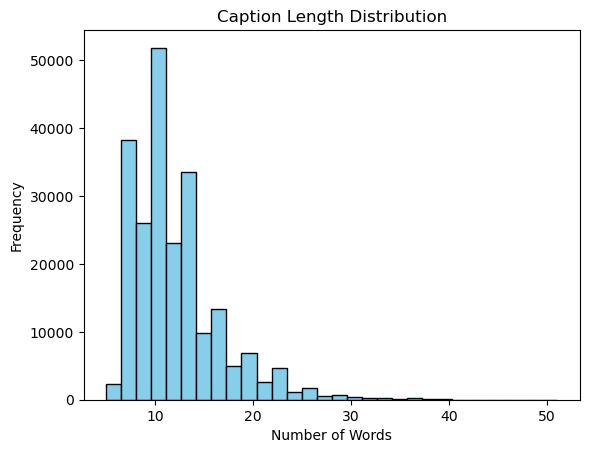

In [69]:
plt.hist(caption_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [43]:
class RSICDDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        
        self.dataframe  = dataframe
        self.images_dir = images_dir
        self.transform  = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        row         = self.dataframe.iloc[idx]
        img_path    = f"{self.images_dir}/{row['filename']}"
        image       = Image.open(img_path).convert('RGB')
        captions    = row[3:].tolist()  # Assuming captions start from 4th column

        if self.transform:
            image = self.transform(image)

        return image, captions


In [44]:
dataset      =   RSICDDataset( data,  path + "resized/"  ) 

In [45]:
len(dataset)

44521

In [46]:
train_data = data[data['split'] == 'train'].reset_index(drop=True)
val_data   = data[data['split'] == 'val'].reset_index(drop=True) 
test_data  = data[data['split'] == 'test'].reset_index(drop=True)

In [47]:
train_dataset = RSICDDataset(train_data, path + "resized/")
val_dataset   = RSICDDataset(val_data,   path + "resized/")
test_dataset  = RSICDDataset(test_data,  path + "resized/") 

In [49]:
len(train_dataset), len(val_dataset),  len(test_dataset) 

(35614, 4453, 4454)

In [51]:
print("Number of train samples:", num_train)
print("Number of val samples:", num_val)
print("Number of test samples:", num_test)

Number of train samples: 35614
Number of val samples: 4453
Number of test samples: 4454


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Training   </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  For Testing (Unseen Data)   </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Dimensions of Scaled-Data  </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:10px;">
<h2>  Model </h2>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  CNN  </h2>
</div>


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  ViT </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Clear CUDA :</h2>
</div>

In [64]:
def  clear_cuda(verbose=None):
    
    import  gc
    
    # 1) Move any models (and large tensors) back to CPU:

    
    # 2) Delete absolutely every reference you might have:
    for name in ["model","optimizer","scheduler","train_loader","val_loader","imgs","bboxes"]:
        if name in globals():
            del globals()[name]
    # Also clear the special notebook underscore variable:
    _ = None
    
    # 3) Force Python garbage collection:
    gc.collect()
    
    # 4) Clear PyTorch’s CUDA cache:
    torch.cuda.empty_cache()

    if verbose:
        # 5) (Optional) Print memory summary to confirm
        print(torch.cuda.memory_summary())


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Loaders :</h2>
</div>

In [65]:
def loaders(batch_size=0, num_workers =0, shuffle=True, transform=None,  test=False):

    dataset      =   AUAIRDataset(    test=False,    transform  =  data_transform)
    train_size   =    int(0.9 * len(dataset))
    val_size     =    len(dataset) - train_size 

    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) 

    train_loader   =   DataLoader(train_dataset, batch_size=batch_size, num_workers  =   num_workers,   pin_memory = True,    shuffle=shuffle)
    val_loader     =   DataLoader(val_dataset,   batch_size=batch_size, num_workers  =   num_workers,   pin_memory = True,    shuffle=shuffle) 

    return     train_loader,     val_loader       



<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Check Number of  Parameters :</h2>
</div>

In [66]:
clear_cuda()

In [67]:
train_loader,   val_loader   =   loaders(batch_size = 32, num_workers = 12, shuffle=True, transform=data_transform,  test=False) 

100%|██████████| 32823/32823 [00:00<00:00, 100877.57it/s]


In [70]:
model_p     =   ViT(n_layers=12, mlp_ratio=4, dropout=0, heads= 16)  

In [71]:
num_params = sum(p.numel() for p in model_p.parameters() if p.requires_grad)

print("Number of trainable parameters in the model:", num_params)

Number of trainable parameters in the model: 14838672


<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Employ GPU</h2>
</div>

In [72]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
device

device(type='cuda')

In [74]:
model      =        model_p.to(device)   

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  To Save Weights and Losses : </h2>
</div>

In [75]:
path_model   =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_weight_1.pth"
path_losses  =  "/home/turgay/Turgay/Academic/2024-2025/Spring/Transformers/Assignments/Assignment_2/weights/Transformer_losses_1.pth"  

In [76]:
if 0:
    
    torch.save({
            'model_state_dict': model.state_dict(),
            'best_loss'       : 9999999999999,
        }, path_model)   

In [77]:
if 0:
    
    torch.save({
        
            'train_loss'    : [],
            'val_loss'      : [], 
    
            'epochs'        : [],
    
        }, path_losses)    

In [78]:
if 1:
    
    checkpoint_weights   =   torch.load(path_model, weights_only=True) 
    checkpoint_losses    =   torch.load(path_losses, weights_only=True)  
    
    model.load_state_dict(checkpoint_weights['model_state_dict'])
    
    best_loss       =  checkpoint_weights['best_loss'] 
    train_loss      =  checkpoint_losses['train_loss']
    val_loss        =  checkpoint_losses['val_loss']
    
    epochs          =  checkpoint_losses['epochs'] 

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Loss Functions : </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2> Sanity Check for loss  </h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Training : </h2>
</div>

In [42]:
def train(num_epochs=0, patience=0, counter=0,  best_loss=best_loss):

    for epoch in range(num_epochs):

        model.train() 
        total_loss_train   =   0
        
        for img, bbox, clas in tqdm.tqdm(train_loader):
            
            img       =   img.to(device)
            bbox      =   bbox.to(device)   
            clas      =   clas.to(device)
            
            optimizer.zero_grad()

            with autocast(device_type='cuda'):


                pred_box, pred_clas         =   model(img)
                

                loss_bbox         =   1 * criterion_l1(pred_box, bbox) + 0 * torchvision.ops.generalized_box_iou_loss(bbox.view(-1, 4), pred_box.view(-1, 4), reduction='mean') 
                loss_bbox         =   10 * loss_bbox
                loss_class        =   criterion_bce(pred_clas, clas)

                loss              =   loss_bbox + loss_class
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            total_loss_train   +=   loss.item()

        total_loss_train   /=   len(train_loader)
        train_loss.append(total_loss_train)
        run.log({"Train Loss": total_loss_train})
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train LOSS : {total_loss_train:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train BBOX : {loss_bbox:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]          |        Total Train CLS  : {loss_class:.4f}           |")
        print("-------------------------------------------------------------------------------")

        model.eval()
        
        total_loss_val   =   0.0

        with torch.no_grad():
            
            for img, bbox, clas in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                
                img       =   img.to(device) 
                bbox      =   bbox.to(device)   
                clas      =   clas.to(device)
            
                with autocast(device_type='cuda'):


                    pred_box, pred_clas         =   model(img)
                

                    loss_bbox         =   1 * criterion_l1(pred_box, bbox) + 0 * torchvision.ops.generalized_box_iou_loss(bbox.view(-1, 4), pred_box.view(-1, 4), reduction='mean') 
                    loss_bbox         =   10 * loss_bbox
                    loss_class        =   criterion_bce(pred_clas, clas)
    
                    loss              =   loss_bbox + loss_class
        
                
                total_loss_val   +=   loss.item()

        total_loss_val   /=   len(val_loader)
        val_loss.append(total_loss_val)
        
        run.log({"Val Loss": total_loss_val})
        
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation LOSS : {total_loss_val:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation BBOX : {loss_bbox:.4f}           |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print(f"|  Epoch [{epoch+1}/{num_epochs}]         |       Total Validation CLS : {loss_class:.4f}           |")
        print("-------------------------------------------------------------------------------")
        
        if len(val_loss) >= 2:
            res       =   ((val_loss[-2] - val_loss[-1]) / val_loss[-2]) * 100
            print("-------------------------------------------------------------------------------")
            print(f"|              Change in loss is      %   {res:.2f}                               |")
            print("-------------------------------------------------------------------------------")
        if total_loss_val < best_loss:
            
            print("*************...saving best model *************")
            best_loss       =   total_loss_val
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_loss': best_loss,
            }, path_model)
        epochs.append(epoch)
        torch.save({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'epochs': epochs,
        }, path_losses)
        if (len(val_loss) >= 2) and (val_loss[-2] > val_loss[-1]):
            counter       =   0
        else:
            counter       +=   1
            if counter >= patience:
                print("Early stopping!")
                break
        scheduler.step()
        torch.cuda.empty_cache()

In [71]:
learning_rate   =  0.0005

In [72]:
optimizer       =   AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0)
criterion_bce   =   nn.BCEWithLogitsLoss()
criterion_l1    =   nn.L1Loss()

run.log({"LRate": learning_rate})  

scheduler       =   torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
scaler          =   GradScaler()

In [73]:
train(num_epochs=25, patience=10, counter=0, best_loss=best_loss)  

100%|██████████| 844/844 [11:18<00:00,  1.24it/s]


-------------------------------------------------------------------------------
|  Epoch [1/25]          |        Total Train LOSS : 0.1604           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]          |        Total Train BBOX : 0.1386           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]          |        Total Train CLS  : 0.0267           |
-------------------------------------------------------------------------------


Epoch 1/25: 100%|██████████| 94/94 [00:48<00:00,  1.95it/s]


-------------------------------------------------------------------------------
|  Epoch [1/25]         |       Total Validation LOSS : 0.1462           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]         |       Total Validation BBOX : 0.1403           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [1/25]         |       Total Validation CLS : 0.0319           |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 844/844 [06:13<00:00,  2.26it/s]


-------------------------------------------------------------------------------
|  Epoch [2/25]          |        Total Train LOSS : 0.1449           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]          |        Total Train BBOX : 0.1131           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]          |        Total Train CLS  : 0.0220           |
-------------------------------------------------------------------------------


Epoch 2/25: 100%|██████████| 94/94 [00:17<00:00,  5.46it/s]


-------------------------------------------------------------------------------
|  Epoch [2/25]         |       Total Validation LOSS : 0.1454           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]         |       Total Validation BBOX : 0.1262           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [2/25]         |       Total Validation CLS : 0.0262           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.55                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 844/844 [05:31<00:00,  2.54it/s]


-------------------------------------------------------------------------------
|  Epoch [3/25]          |        Total Train LOSS : 0.1442           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]          |        Total Train BBOX : 0.1339           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]          |        Total Train CLS  : 0.0271           |
-------------------------------------------------------------------------------


Epoch 3/25: 100%|██████████| 94/94 [00:17<00:00,  5.51it/s]


-------------------------------------------------------------------------------
|  Epoch [3/25]         |       Total Validation LOSS : 0.1445           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]         |       Total Validation BBOX : 0.0977           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [3/25]         |       Total Validation CLS : 0.0178           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.59                               |
-------------------------------------------------------------------------------
*************...saving best model *************


100%|██████████| 844/844 [05:32<00:00,  2.54it/s]


-------------------------------------------------------------------------------
|  Epoch [4/25]          |        Total Train LOSS : 0.1438           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]          |        Total Train BBOX : 0.1390           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]          |        Total Train CLS  : 0.0213           |
-------------------------------------------------------------------------------


Epoch 4/25: 100%|██████████| 94/94 [00:16<00:00,  5.64it/s]


-------------------------------------------------------------------------------
|  Epoch [4/25]         |       Total Validation LOSS : 0.1444           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]         |       Total Validation BBOX : 0.0927           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|  Epoch [4/25]         |       Total Validation CLS : 0.0143           |
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|              Change in loss is      %   0.08                               |
-------------------------------------------------------------------------------
*************...saving best model *************


 27%|██▋       | 232/844 [01:33<04:06,  2.48it/s]


KeyboardInterrupt: 

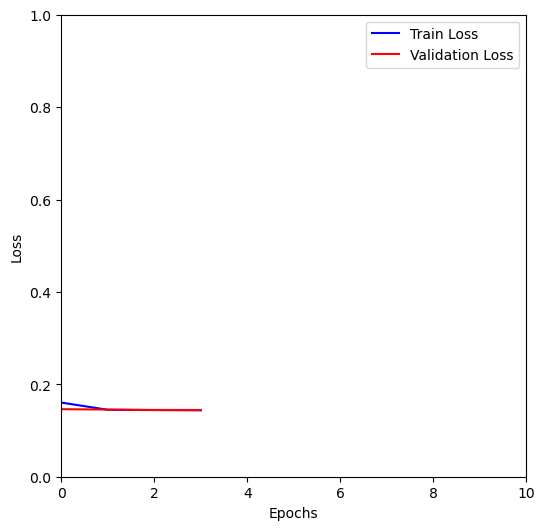

In [96]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(train_loss, "b-", label="Train Loss")
ax.plot(val_loss, "r-", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_xlim([0, 10])
ax.set_ylim([0,1])

ax.legend()

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Results : </h2>
</div>

In [97]:
e  =  model.eval()

In [98]:
for imgs, bbox, clas in train_loader:
    break

In [99]:
imgs.shape

torch.Size([32, 3, 360, 640])

In [100]:
bbox.shape

torch.Size([32, 60, 4])

In [125]:
num  =  7

In [126]:
with torch.no_grad():

    img            =     (imgs).to(device) 

    p_box, clas          =     model(img)       
    


In [127]:
p_box[0][:5]

tensor([[3.8835e-01, 5.1563e-01, 9.6944e-02, 6.4924e-02],
        [1.9195e-01, 3.1988e-01, 4.6286e-02, 4.4849e-02],
        [3.1621e-03, 7.0171e-04, 8.4361e-03, 8.0962e-03],
        [1.4171e-05, 1.0747e-05, 1.7187e-05, 8.2831e-06],
        [1.7239e-05, 8.4760e-06, 1.3381e-05, 1.8683e-05]], device='cuda:0')

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Evaluation Metrices</h2>
</div>

<div span style="background-color:yellow;    color:red;      text-align:center;    padding:5px;">
<h2>  Sync for WANDB</h2>
</div>

In [ ]:
#run.finish() 